### 전체 프로세스 정리
0. 데이터셋 적재
1. 전처리(결측치 및 이상치)
    - 결측치 없음
    - 거래금액(y)의 분포가 왼쪽으로 치우쳐져, 로그 변환을 통해 정규화 진행
2. 훈련셋과 테스트셋 데이터 분리
    - train_test_split 함수를 사용하여 데이터를 학습 데이터와 테스트 데이터로 분리합니다.
    - test_size=0.2는 전체 데이터의 20%를 테스트 데이터로 사용하겠다는 의미입니다.
3. 모델(RandomForest, XGBoost)
    - 각각 모델을 선언한다. + 각 모델에 대한 설명
    - 훈련 데이터셋으로 학습을 진행한다.
4. 테스트 데이터셋을 통해 모델의 성능을 검증한다.
    - 이 때, MAE와 MAPE를 평가지표로 활용합니다.
    - 실제 값(y)와 예측 값(ŷ) 비교합니다.
5. 변수 중요도
    - 각 모델 라이브러리에 내장된 importance 메서드를 통해<br>모델 생성시 중요 변수들을 파악합니다.

In [ ]:
### matplotlib 한글 폰트 깨짐 방지
### 이 셀 실행시키고 런타임->런타임 다시 시작 한 다음에
### 이 셀은 건너뛰고 아래부터 실행 시키면 됨.

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 21 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 1s (7,272 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# 필요한 라이브러리 호출
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
plt.rc('font', family='NanumBarunGothic')
import warnings
warnings.filterwarnings(action='ignore')

### 0. 데이터 적재

In [ ]:
# 데이터 프레임 선언
df = pd.read_csv("bundang.csv")
# 불필요한 컬럼 제거
df = df.drop(columns=['시군구','단지명','건축년도'])
# 데이터 미리보기
df.head()

,전용면적,층,경과년수,지하철,대형몰,병원,최고층,총세대수,용적률,건폐율,거래금액
0,42.12,2,23,0.46,0.4,2.2,8,342,422,74,15100
1,50.22,4,23,0.46,0.4,2.2,8,342,422,74,17600
2,42.12,2,23,0.46,0.4,2.2,8,342,422,74,14600
3,84.24,5,23,0.46,0.4,2.2,8,342,422,74,27000
4,42.12,7,23,0.46,0.4,2.2,8,342,422,74,15300


### 1. 데이터 전처리

In [ ]:
# 컬럼 별 결측치 확인
df.isna().sum()

전용면적    0
층       0
경과년수    0
지하철     0
대형몰     0
병원      0
최고층     0
총세대수    0
용적률     0
건폐율     0
거래금액    0
dtype: int64

(array([  2.,   5.,  21.,  69., 162., 146., 148., 144., 122.,  97., 149.,
         75.,  59.,  59.,  16.,  13.,  14.,  23.,  22.,  34.,  15.,  22.,
         24.,  13.,   8.,  17.,  13.,  15.,   3.,  11.,  15.,  13.,   7.,
         12.,  12.,   5.,   7.,   4.,  12.,   3.,   3.,   7.,   4.,  11.,
          4.,   5.,   6.,   1.,   1.,   2.,   3.,   3.,   1.,   2.,   5.,
          2.,   1.,   1.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,   3.,
          0.,   3.,   0.,   1.,   3.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.]),
 array([  8000.,   9870.,  11740.,  13610.,  15480.,  17350.,  19220.,
         21090.,  22960.,  24830.,  26700.,  28570.,  30440.,  32310.,
         34180.,  36050.,  37920.,  39790.,  41660.,  43530.,  45400.,
         47270.,  49140.,  51010.,  52880.,  54750.,  56620.,  58490.,
         60360.,  62230.,  64100.,

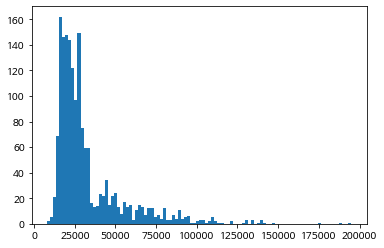

In [ ]:
# 거래금액에 대한 분포 시각화
# bins=100은 100개의 구간으로 나눔을 의미
plt.hist(df['거래금액'],bins=100)

- 시각화된 결과에서 왼쪽으로 치우쳐진 분포를 보임
- 이에 따라, 이후 로그 변환을 통해 정규화 진행
    - Tree 계열에서는 대체로 정규화를 하지 않아도, 우수한 성능을 보임

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  0.,  4.,  0.,  0.,  8.,
         3.,  2.,  2., 10.,  8., 13., 29., 37., 41., 59., 36., 30., 52.,
        44., 58., 55., 31., 67., 85., 20., 56., 47., 47., 49., 40., 57.,
        76., 49., 30., 30., 28., 32., 24.,  9., 12., 10.,  5., 18., 12.,
        17., 16., 27., 11., 18., 22., 15.,  6., 16., 10., 15.,  7.,  9.,
        19., 13., 18.,  8.,  9.,  8.,  5., 14.,  6.,  7., 14.,  5.,  8.,
         2.,  4.,  4.,  4.,  7.,  1.,  1.,  1.,  0.,  4.,  3.,  4.,  1.,
         1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  2.]),
 array([ 8.98732181,  9.01925619,  9.05119058,  9.08312496,  9.11505934,
         9.14699372,  9.1789281 ,  9.21086248,  9.24279687,  9.27473125,
         9.30666563,  9.33860001,  9.37053439,  9.40246877,  9.43440315,
         9.46633754,  9.49827192,  9.5302063 ,  9.56214068,  9.59407506,
         9.62600944,  9.65794382,  9.68987821,  9.72181259,  9.75374697,
         9.78568135,  9.81761573,  9.84955011,  9.8814845 ,  9.913418

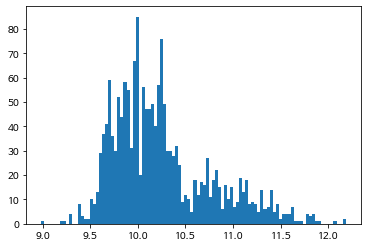

In [ ]:
# 로그 변환를 통해 정규화 진행
df['거래금액_log'] = np.log(df['거래금액']+1)
# 정규화 이전 데이터 drop
df = df.drop(columns=['거래금액'])
# 정규화한 이후의 거래금액 분포 시각화
plt.hist(df['거래금액_log'],bins=100)

### 2. 데이터셋 분리 및 모델 선언(RandomForestRegressor)

#### 랜덤 포레스트(Random Forest)

랜덤 포레스트는 앙상블 학습 방법의 하나로, 여러 개의 결정 트리(Decision Trees)를 생성하고 그 예측들을 결합함으로써 작동합니다. 이 알고리즘은 강력한 모델을 만들기 위해 여러 약한 모델들을 결합하는 것을 목표로 하는 '배깅(Bagging)' 방법의 한 예입니다.

<div style="text-align: center;">
    <img src="../img/RF.png" width="500"/><br>
    (이미지 출처: <a href="https://neocarus.tistory.com/entry/Random-forest-%EC%9E%91%EB%8F%99-%EC%9B%90%EB%A6%AC">출처 링크</a>)
</div>

#### 작동 원리

1. **부트스트랩 샘플링(Bootstrap Sampling)**: 원래 데이터셋에서 무작위로 샘플을 선택하여(복원 추출 방식으로) 새로운 데이터셋을 만듭니다. 이렇게 만들어진 새로운 데이터셋으로 결정 트리를 학습합니다. 

2. **특성 무작위 선택**: 각 노드에서 전체 특성(feature)이 아닌 무작위로 선택된 일부 특성만 고려하여 최적의 분할을 찾습니다. 이는 모델의 다양성을 더욱 증가시키고, 과적합을 줄이는 데 도움이 됩니다.

3. **예측**: 회귀 문제의 경우, 각 트리의 예측을 평균하여 최종 예측을 얻습니다. 분류 문제의 경우, 각 트리의 예측을 '투표'로 취급하고 가장 많은 표를 얻은 클래스를 최종 예측으로 합니다.

#### 장점

- 강력하고 유연한 모델: 랜덤 포레스트는 다양한 종류의 데이터셋에 대해 잘 작동하며, 회귀와 분류 문제 모두에 사용할 수 있습니다.

- 특성 중요도 계산: 랜덤 포레스트는 각 특성의 중요도를 측정하며, 이를 통해 모델의 해석이나 특성 선택에 도움이 됩니다.

- 과적합 방지: 부트스트랩 샘플링과 특성 무작위 선택으로 인해 개별 트리의 과적합이 평균화되므로, 랜덤 포레스트 전체는 과적합에 덜 민감합니다.

#### 단점

- 예측 속도: 랜덤 포레스트는 많은 트리를 포함하므로, 예측 시간이 다른 모델들(예: 선형 모델)보다 느릴 수 있습니다.

- 해석이 어렵다: 랜덤 포레스트의 예측은 수 많은 트리에 기반하므로, 개별 트리보다는 해석이 어렵습니다. 다만, 이는 다른 복잡한 머신러닝 모델들도 마찬가지의 문제를 가지고 있습니다.

In [ ]:
# 훈련셋과 테스트셋 분리를 위한 라이브러리
from sklearn.model_selection import train_test_split
# RandomForest 모델을 선언하기 위한 라이브러리
from sklearn.ensemble import RandomForestRegressor

# 로그 변환하여 정규화 시킨 Y값
Y = df['거래금액_log'].values
# float형태로 변환
Y = Y.astype('float32')
# 종속변수인 Y값을 제외하고, 독립변수들을 'X'라는 변수에 담음
X = df.drop(columns=['거래금액_log'])
# float형태로 변환
X = X.astype('float32')

# train_test_split 함수를 사용하여 데이터를 학습 데이터와 테스트 데이터로 분리합니다.
# test_size=0.2는 전체 데이터의 20%를 테스트 데이터로 사용하겠다는 의미입니다.
# random_state=42는 재현 가능성을 위해 설정한 값입니다. 이 값이 같다면 코드를 여러번 실행해도 항상 같은 결과를 얻을 수 있습니다.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=42)

# RandomForestRegressor 모델을 생성합니다. 
# n_estimators=2000은 랜덤 포레스트 안에 생성될 결정 트리의 개수를 2000개로 설정합니다.
# random_state=42는 모델의 결과를 재현하기 위한 값입니다.
RF_model = RandomForestRegressor(n_estimators=2000, random_state=42)

# RandomForestRegressor 모델을 학습 데이터에 대해 학습시킵니다.
RF_model.fit(X_train,Y_train)

RandomForestRegressor(n_estimators=2000, random_state=42)

### 3. Random Forest 모델 예측 및 성능 평가

- MAE(Mean Absolute Error)
    - 평균 절대 오차(MAE)는 실제 값과 예측 값의 절대적인 차이를 평균한 것입니다. MAE는 모든 개별 오차의 절대 값을 합산한 후, 그 합을 샘플의 개수로 나누어 계산
    $$\mathrm{MAE}=\frac{1}{n} \sum_{i=1}^n\left|y_i-\hat{y}_i\right|$$
    
- MAPE(Mean Absolute Percetage Error)
    - 평균 절대 백분율 오차(MAPE)는 실제 값 대비 예측 값의 오차를 백분율로 나타낸 것의 평균
    $$\mathrm{MAPE}=\frac{100}{n} \sum_{i=1}^n\left|\frac{y_i-\hat{y}_i}{y_i}\right|$$
    
- 두 지표는 모두 값이 작을수록 모델의 성능이 더 좋다는 것을 의미합니다.

In [ ]:
# 학습 데이터에 대한 예측을 수행합니다.
Train_Prediction = (RF_model.predict(X_train))

# 테스트 데이터에 대한 예측을 수행합니다.
Test_Prediction = (RF_model.predict(X_test))

# 학습 데이터에 대한 Mean Absolute Error(MAE)를 계산합니다.
# MAE는 실제 값과 예측 값의 차이를 절댓값으로 변환한 후 평균을 낸 것입니다.
RF_Train_MAE = round(np.mean(np.abs(Y_train-Train_Prediction)),3)

# 학습 데이터에 대한 Mean Absolute Percentage Error(MAPE)를 계산합니다.
# MAPE는 실제 값과 예측 값의 차이를 절댓값으로 변환한 후, 이를 실제 값으로 나눠서 퍼센트로 표현한 값의 평균입니다.
RF_Train_MAPE = round((np.mean(np.abs((Y_train-Train_Prediction)/(Y_train)))*100),3)

# 테스트 데이터에 대한 Mean Absolute Error(MAE)를 계산합니다.
RF_Test_MAE = round(np.mean(np.abs(Y_test-Test_Prediction)),3)

# 테스트 데이터에 대한 Mean Absolute Percentage Error(MAPE)를 계산합니다.
RF_Test_MAPE = round((np.mean(np.abs((Y_test-Test_Prediction)/(Y_test)))*100),3)

# 학습 데이터에 대한 MAE를 출력합니다.
print("Mean Absolute Error for Train Set is : {:.3f}".format(RF_Train_MAE))

# 학습 데이터에 대한 MAPE를 출력합니다.
print("Mean Absolute Percent Error for Train Set is : {:.3f} %".format(RF_Train_MAPE))

# 테스트 데이터에 대한 MAE를 출력합니다.
print("Mean Absolute Error for Test Set is : {:.3f}".format(RF_Test_MAE))

# 테스트 데이터에 대한 MAPE를 출력합니다.
print("Mean Absolute Percent Error for Test Set is : {:.3f} %".format(RF_Test_MAPE))

Mean Absolute Error for Train Set is : 0.025
Mean Absolute Percent Error for Train Set is : 0.242 %
Mean Absolute Error for Test Set is : 0.057
Mean Absolute Percent Error for Test Set is : 0.544 %


### 4. 실제 값(y)와 예측 값(ŷ) 비교

In [ ]:
# 테스트 데이터에 대한 예측 값을 원래의 단위로 변환합니다.
# np.exp를 사용하여 로그 변환을 취소하고, np.round를 사용하여 반올림합니다. -2는 소수점 두 번째 자리에서 반올림하겠다는 의미입니다.
# 마지막으로 astype(int)를 사용하여 정수로 변환합니다.
Original_Predictions = (np.round(np.exp(Test_Prediction+1),-2)).astype(int)

# 첫 10개의 변환된 예측 값을 출력합니다.
print(Original_Predictions[:10])

# 실제 테스트 데이터의 값을 원래의 단위로 변환합니다.
# 변환 과정은 예측 값과 동일합니다.
Original_Values = (np.round(np.exp(Y_test+1),-2)).astype(int)

# 첫 10개의 변환된 실제 값을 출력합니다.
print(Original_Values[:10])

# 변환된 실제 값과 예측 값을 딕셔너리로 만들어 줍니다.
data = {'Original':  Original_Values,'Prediction': Original_Predictions}

# 위에서 만든 딕셔너리를 사용하여 데이터프레임을 생성합니다.
final = pd.DataFrame(data)

# 최종 데이터프레임을 출력합니다.
final

[ 44500  57300 158300 188800 353700  81700 211400  65500  58200  41900]
[ 45700  59800 154900 182100 312600  59800 201200  59800  58400  42400]


,Original,Prediction
0,45700,44500
1,59800,57300
2,154900,158300
3,182100,188800
4,312600,353700
...,...,...
334,69300,75800
335,187300,225600
336,44900,43900
337,53000,55000


### 5. 변수 중요도 시각화

#### 계산 방법

특성 중요도는 각 결정 트리에서 특성을 기반으로 한 분할이 불순도(impurity)를 얼마나 감소시키는지를 기반으로 합니다. 각 특성의 중요도는 먼저 트리 내에서 계산되고, 그런 다음 각 트리의 예측에 대한 비중으로 평균화됩니다. 이렇게 하면 각 특성이 전체 랜덤 포레스트 모델에서 얼마나 중요한지를 알 수 있습니다.

$$\operatorname{Gain}(S, A)=\underbrace{\operatorname{Entropy}(S)}_{\text {original entropy of } \mathrm{S}}-\underbrace{\sum_{v \in \text { values }(A)} \frac{\left|S_v\right|}{|S|} \cdot \operatorname{Entropy}\left(S_v\right)}_{\text {relative entropy of } \mathrm{S}}$$

위의 수식은 의사 결정 트리에서 특성 선택을 위해 사용하는 '정보 획득(Information Gain)'을 계산하는 방법을 설명하고 있습니다. 정보 획득은 어떤 특성을 사용하여 데이터를 분할했을 때, 얼마나 많은 '불확실성' 또는 '엔트로피(Entropy)'가 감소하는지를 측정합니다.

<br>
<div style="text-align: center;">
    <img src="../img/IG.png" width="500"/><br>
    (이미지 출처: <a href="https://sebastianraschka.com/faq/docs/decisiontree-error-vs-entropy.html">출처 링크</a>)
</div>
<br>
여기서 S는 현재의 데이터 집합을, A는 분할을 위해 고려 중인 특성을 나타냅니다.

- $$\operatorname{Entropy}(S_{v})$$
    원래 데이터 집합 \(S\)의 엔트로피를 나타냅니다. 이는 데이터 집합의 불확실성을 측정하는 지표입니다. 엔트로피가 높을수록 데이터 집합에는 많은 정보가 포함되어 있고, 이는 예측을 어렵게 만듭니다.

- $$\sum_{v \in \text{ values }(A)} \frac{\left|S_v\right|}{|S|} \cdot \operatorname{Entropy}\left(S_v\right)\$$

    이 부분은 특성 \(A\)의 각 값에 대해 데이터 집합을 분할했을 때의 '평균 엔트로피'를 나타냅니다.
- $$\left|S_v\right|$$
    특성 A의 값이 v인 데이터의 수
- $$|S|$$
    전체 데이터 집합의 크기를 나타냅니다. 따라서, 이 합은 각 부분 집합의 크기에 따른 가중치를 고려하여, 분할 후의 평균 엔트로피를 계산합니다.

따라서 전체 수식은 원래 데이터 집합의 엔트로피에서 분할 후의 평균 엔트로피를 뺀 값, 즉 특성 \(A\)를 사용하여 데이터를 분할했을 때 얼마나 많은 정보를 획득하는지를 나타냅니다. 정보 획득이 클수록 해당 특성은 데이터를 잘 분류하는 데 유용하다고 볼 수 있습니다.

Text(0.5, 0, 'Random Forest Feature Importance')

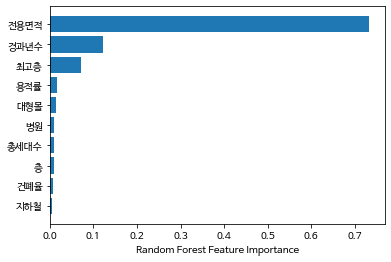

In [ ]:
# 랜덤 포레스트 모델의 특성 중요도를 기준으로 정렬합니다.
# argsort() 함수는 작은 값부터 큰 값 순서로 데이터의 인덱스를 반환합니다.
sorted_idx = RF_model.feature_importances_.argsort()

# 특성 중요도를 수평 막대 그래프로 그립니다.
# X.columns[sorted_idx]는 중요도 순서대로 정렬된 특성의 이름을 가져옵니다.
# RF_model.feature_importances_[sorted_idx]는 중요도 순서대로 정렬된 특성 중요도를 가져옵니다.
plt.barh(X.columns[sorted_idx], RF_model.feature_importances_[sorted_idx])

# x축 레이블을 설정합니다.
plt.xlabel("Random Forest Feature Importance")

### 6. 데이터셋 분리 및 모델 선언(XGBoost)

## XGBoost(eXtreme Gradient Boosting)

Gradient Boosting 알고리즘을 기반으로 하는 머신러닝 라이브러리입니다. Gradient Boosting 알고리즘은 여러 개의 약한 학습기(weak learner)를 결합하여 강한 학습기(strong learner)를 만드는 앙상블 기법입니다. 이 때 약한 학습기로 일반적으로 의사 결정 나무(decision tree)가 사용됩니다. XGBoost는 기본 Gradient Boosting 알고리즘에 여러 가지 최적화 기법과 정규화(regularization) 등을 추가하여 성능을 향상시킨 알고리즘입니다.

<br>
<div style="text-align: center;">
    <img src="../img/xgboost.png" width="500"/><br>
    (이미지 출처: <a href="https://docs.aws.amazon.com/ko_kr/sagemaker/latest/dg/xgboost-HowItWorks.html">출처 링크</a>)
</div>
<br>

XGBoost의 주요 특징은 다음과 같습니다:

1. **정규화(Regularization)**: XGBoost는 기본적인 Gradient Boosting 알고리즘에 L1(Lasso Regression) 및 L2(Ridge Regression) 정규화를 추가하였습니다. 이는 모델의 과적합(overfitting)을 방지하며, 일반화 성능을 향상시킵니다.

2. **병렬 처리(Parallel Processing)**: XGBoost는 다중 코어를 활용한 병렬 처리를 지원하여 학습 속도를 빠르게 할 수 있습니다.

3. **핸들링 능력(Handling Missing Values)**: XGBoost는 결측치 처리 기능을 내장하고 있어, 별도의 결측치 처리 과정 없이도 모델을 학습시킬 수 있습니다.

4. **트리 가지치기(Tree Pruning)**: XGBoost는 중요하지 않은 피처를 가지치기(pruning)하여 모델의 복잡도를 줄이고, 과적합을 방지합니다.

5. **교차 검증(Cross-Validation)**: XGBoost에는 내장된 교차 검증 기능이 있어, 매 반복마다 학습 데이터를 사용하여 교차 검증을 수행할 수 있습니다.

In [ ]:
# xgboost 라이브러리를 가져옵니다.
import xgboost

# train_test_split 함수를 사용하여 데이터를 학습 데이터와 테스트 데이터로 분리합니다.
# test_size=0.2는 전체 데이터의 20%를 테스트 데이터로 사용하겠다는 의미입니다.
# random_state=41은 재현 가능성을 위해 설정한 값입니다. 이 값이 같다면 코드를 여러번 실행해도 항상 같은 결과를 얻을 수 있습니다.
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.2, random_state=41)

# XGBRegressor 모델을 생성합니다. 
# n_estimators=2000은 부스팅 단계의 수를 의미하며, 이는 결정 트리의 개수에 해당합니다.
# random_state=41은 모델의 결과를 재현하기 위한 값입니다.
XGB_model = xgboost.XGBRegressor(n_estimators=2000, random_state=41)

# XGBRegressor 모델을 학습 데이터에 대해 학습시킵니다.
XGB_model.fit(X_train,Y_train)

[04:08:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=2000, random_state=41)

### 7. XGB 모델 - 성능 평가

In [ ]:
# 학습 데이터에 대한 예측을 수행합니다.
Train_Prediction = (XGB_model.predict(X_train))

# 테스트 데이터에 대한 예측을 수행합니다.
Test_Prediction = (XGB_model.predict(X_test))

# 학습 데이터에 대한 Mean Absolute Error(MAE)를 계산합니다.
# MAE는 실제 값과 예측 값의 차이를 절댓값으로 변환한 후 평균을 낸 것입니다.
XGB_Train_MAE = round(np.mean(np.abs(Y_train-Train_Prediction)),3)

# 학습 데이터에 대한 Mean Absolute Percentage Error(MAPE)를 계산합니다.
# MAPE는 실제 값과 예측 값의 차이를 절댓값으로 변환한 후, 이를 실제 값으로 나눠서 퍼센트로 표현한 값의 평균입니다.
XGB_Train_MAPE = round((np.mean(np.abs((Y_train-Train_Prediction)/(Y_train)))*100),3)

# 테스트 데이터에 대한 Mean Absolute Error(MAE)를 계산합니다.
XGB_Test_MAE = round(np.mean(np.abs(Y_test-Test_Prediction)),3)

# 테스트 데이터에 대한 Mean Absolute Percentage Error(MAPE)를 계산합니다.
XGB_Test_MAPE = round((np.mean(np.abs((Y_test-Test_Prediction)/(Y_test)))*100),3)

# 학습 데이터에 대한 MAE를 출력합니다.
print("Mean Absolute Error for Train Set is : {:.3f}".format(XGB_Train_MAE))

# 학습 데이터에 대한 MAPE를 출력합니다.
print("Mean Absolute Percent Error for Train Set is : {:.3f} %".format(XGB_Train_MAPE))

# 테스트 데이터에 대한 MAE를 출력합니다.
print("Mean Absolute Error for Test Set is : {:.3f}".format(XGB_Test_MAE))

# 테스트 데이터에 대한 MAPE를 출력합니다.
print("Mean Absolute Percent Error for Test Set is : {:.3f} %".format(XGB_Test_MAPE))

Mean Absolute Error for Train Set is : 0.025
Mean Absolute Percent Error for Train Set is : 0.239 %
Mean Absolute Error for Test Set is : 0.053
Mean Absolute Percent Error for Test Set is : 0.503 %


### 8. XGB 모델 - 변수 중요도

#### 계산 방법

기본적으로 "F score"라는 메트릭을 사용하여 각 특성의 중요도를 계산합니다. F score는 각 특성이 모델에서 얼마나 자주 사용되는지를 측정하는 메트릭입니다.

XGBoost의 특성 중요도는 다음과 같은 방식으로 계산됩니다:

    1. F score: 모델의 각 트리에서 특성이 분할에 사용된 횟수를 카운트합니다. 더 많이 사용된 특성일수록 더 중요하다고 판단합니다.

    2. Gain: 각 특성이 트리에서 수행하는 분할에 기여하는 평균적인 "Gain"을 측정합니다. Gain은 분할 전후의 손실 함수의 감소량을 의미합니다. Gain이 높은 특성일수록 더 중요하다고 판단합니다.
    
$$\operatorname{Gain}(S, A)=\underbrace{\operatorname{Entropy}(S)}_{\text {original entropy of } \mathrm{S}}-\underbrace{\sum_{v \in \text { values }(A)} \frac{\left|S_v\right|}{|S|} \cdot \operatorname{Entropy}\left(S_v\right)}_{\text {relative entropy of } \mathrm{S}}$$

    3. Coverage: 각 특성이 트리에서 수행하는 분할에서 얼마나 많은 샘플을 커버하는지를 측정합니다. 더 많은 샘플을 커버하는 특성일수록 더 중요하다고 판단합니다.

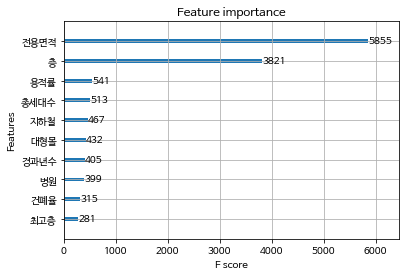

In [ ]:
# XGBRegressor 모델의 특성 중요도를 그래프로 표시합니다.
# 이 함수는 각 특성의 중요도를 수평 막대 그래프로 그려줍니다.
xgboost.plot_importance(XGB_model)